# Evaluate likelihood ratio

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Setting

In [43]:
setting = "mass"

In [44]:
plot_grads = False

## Data

In [45]:
xs = np.load("../data/samples/x_test_{}_point.npy".format(setting))
#xs = np.ones((1000, 64, 64))

In [46]:
idx = list(range(20,30))
nrows = len(idx)

In [47]:
filenames = [
    "carl",
    "alice",
    "alices",
]
labels = [
    "CARL",
    "ALICE",
    "ALICES",
]
colors = ["red", "green", "yellow"]*4
nmethods = len(filenames)
ncols = len(filenames) + 1

In [48]:
llrs = np.asarray([np.load("../data/results/llr_{}_{}_grid.npy".format(filename, setting)) for filename in filenames])
if plot_grads:
    grads = np.asarray([np.load("../data/results/grad_x_{}_{}_grid.npy".format(filename, setting))[:100] for filename in filenames])
    grad_logs = grads * xs[np.newaxis, :grads.shape[1]]
    rel_grads = np.abs(grad_logs) / np.sum(np.abs(grad_logs).reshape(grad_logs.shape[0], grad_logs.shape[1], -1), axis=2)[:,:,np.newaxis, np.newaxis]


In [49]:
llrs[0].shape

(625, 100000)

In [81]:
np.min(llrs[0]), np.max(llrs[0])

(0.001040997, 0.001040997)

In [50]:
expected_llr = np.mean(llrs, axis=-1)
sum_llr_100 = np.sum(llrs[:100], axis=-1)
expected_x = np.mean(xs, axis=0)
#expected_rel_grad = np.mean(rel_grads, axis=1)

## Parameter grids

In [64]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Plotting options

In [68]:
llrmin, llrmax = -0.01, 0.01
gradmin, gradmax = -0.1, 0.1
gradrelmax = 0.002
xmin, xmax = 2.3, 3.2

llr_cmap = "PRGn_r"


In [69]:
grad_rel = True
alpha_grad = 0.5

if grad_rel:
    grad_rel_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., grad_rel_color), (1., grad_rel_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.linspace(0., alpha_grad, overlay_cmap.N + 3)
    overlay_cmap._lut[:,-1] = alphas
    
else:
    pos_grad_color = colorConverter.to_rgba("C0")[:3]
    neg_grad_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., neg_grad_color), (0.499, neg_grad_color), (0.501, pos_grad_color), (1., pos_grad_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.asarray(
        list(np.linspace(alpha_grad, 0, overlay_cmap.N // 2 + 1))
        + [0.]
        + list(np.linspace(0., alpha_grad, overlay_cmap.N // 2 + 1))
    )
    overlay_cmap._lut[:,-1] = alphas

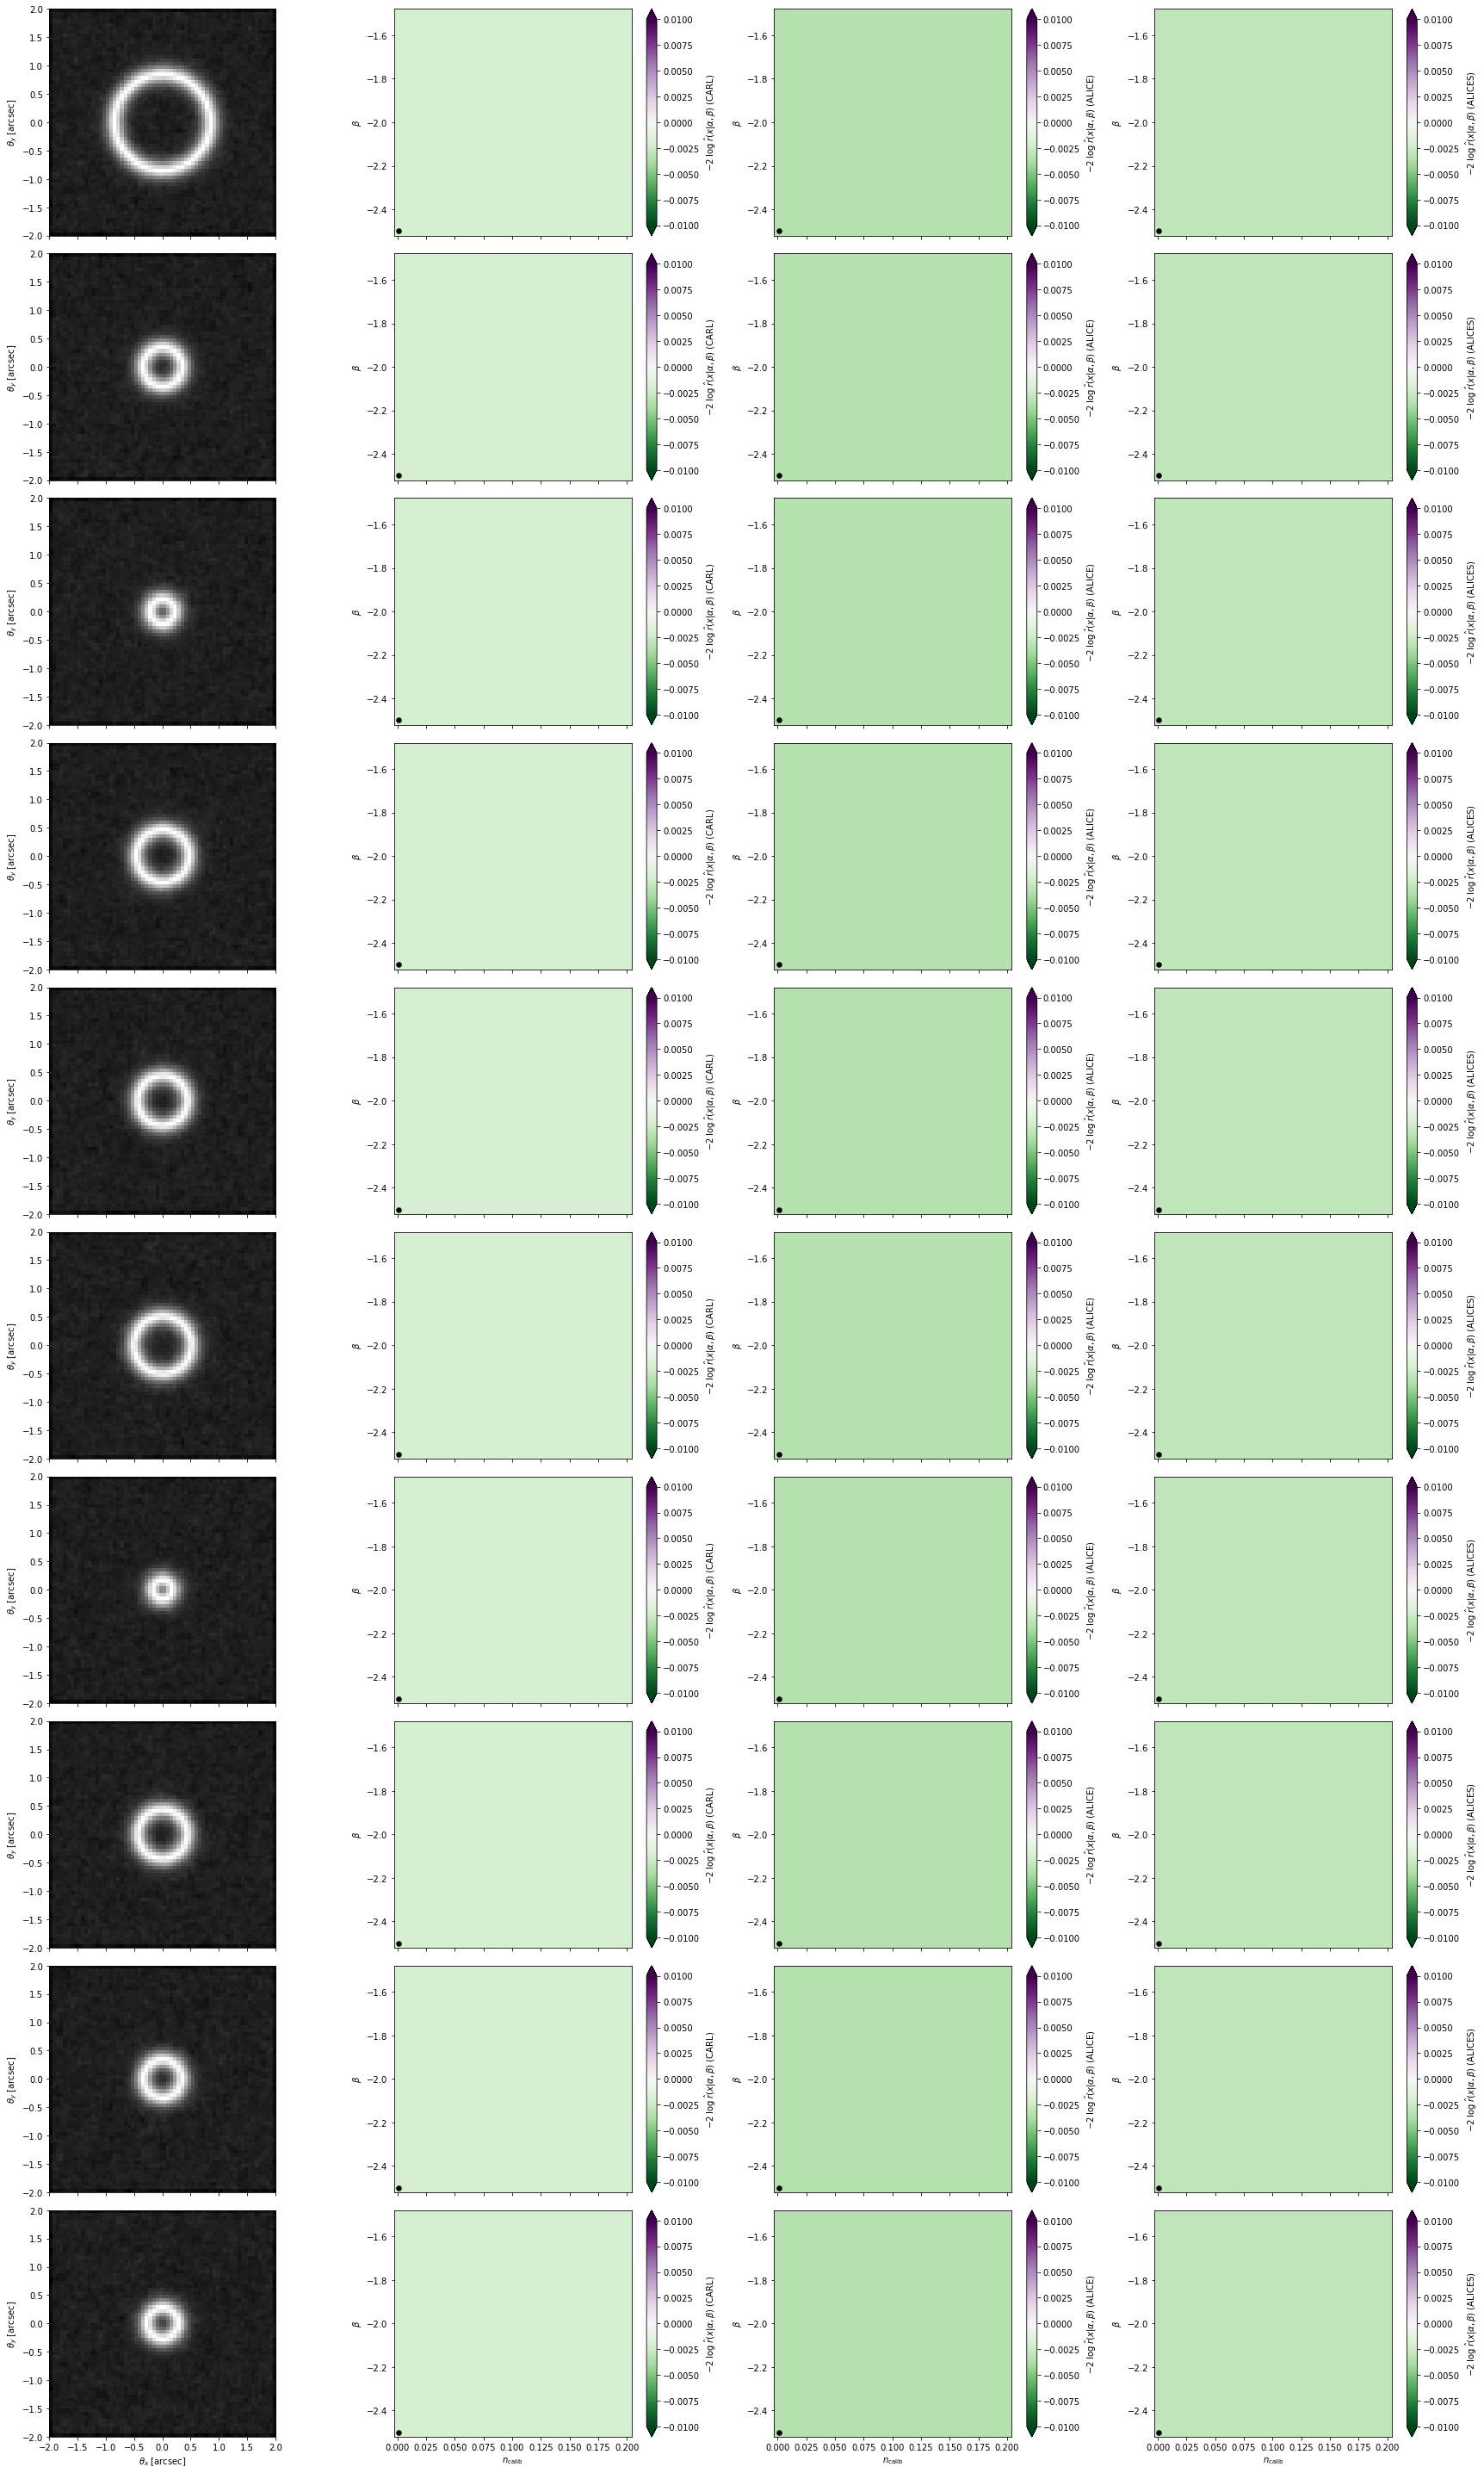

In [70]:
fig = plt.figure(figsize=(6.*ncols, 4*nrows))
ax_xs = []
ax_rs = []
k_grad = 0

for i in [nrows - 1] + list(range(nrows - 1)):
    i_img = idx[i]

    # Plot image
    if i == nrows - 1:
        ax_xs = plt.subplot(nrows, ncols, i*ncols + 1)
        ax = ax_xs
    else:
        ax = plt.subplot(nrows, ncols, i*ncols + 1, sharex=ax_xs)

    plt.imshow(
        np.log10(xs[i_img]),
        vmin=xmin,
        vmax=xmax,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower",
        alpha=1.
    )
    if plot_grads:
        if grad_rel:
            im = plt.imshow(
                rel_grads[k_grad][i_img],
                vmin=0.,
                vmax=gradrelmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        else:
            im = plt.imshow(
                grad_logs[k_grad][i_img],
                vmin=gradmin,
                vmax=gradmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        cbar = fig.colorbar(im, ax=ax, extend='max')

    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    if i == nrows - 1:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    if plot_grads:
        if grad_rel:
            cbar.set_label(
                r'$1/Z \; |\nabla_{\log x_{ij}} \log \;\hat{r}(x | \alpha_0, \beta,0)|$ ' + '({})'.format(labels[k])
            )
        else:
            cbar.set_label(
                r'$\nabla_{\log x_{ij}} \log \;\hat{r}(x | \alpha_0, \beta,0)$ ' + '({})'.format(labels[k])
            )
    
    for k in range(nmethods):
        # Plot estimated likelihood ratios
        if i == nrows - 1:
            ax_rs.append(plt.subplot(nrows, ncols, i*ncols + k + 2))
            ax = ax_rs[k]
        else:
            ax = plt.subplot(nrows, ncols, i*ncols + k + 2, sharex=ax_rs[k])
        
        i_mle = np.argmax(llrs[k][:, i_img])
        theta_mle = theta_grid[i_mle]
        z = np.clip(-2. * llrs[k][:, i_img], llrmin, llrmax)
    
        pcm = ax.pcolormesh(
            alpha_edges,
            beta_edges,
            z.reshape((resolution, resolution)),
            norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
            cmap=llr_cmap
        )
        cbar = fig.colorbar(pcm, ax=ax, extend='both')
        plt.scatter(150., -1.9, s=60., color='black', marker='*')
        plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

        if i == nrows - 1:
            plt.xlabel(r'$n_{\mathrm{calib}}$')
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r'$\beta$')
        cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
        plt.xlim(alpha_edges[0], alpha_edges[-1])
        plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/predictions_{}.pdf".format(setting))

## Expected LLR

In [77]:
n = 1.
llrmin, llrmax = 0., 0.000001
gradmin, gradmax = -0.1, 0.1
gradrelmax = 0.0004
xmin, xmax = 2.4, 2.65

llr_cmap = "viridis_r"


In [78]:
alpha_grad = 0.75

grad_rel_color = colorConverter.to_rgba("C1")[:3]

overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'overlay_cmap',
    [(0., grad_rel_color), (1., grad_rel_color)],
    512
)
overlay_cmap._init()
alphas = np.linspace(0., alpha_grad, overlay_cmap.N + 3)
overlay_cmap._lut[:,-1] = alphas
    

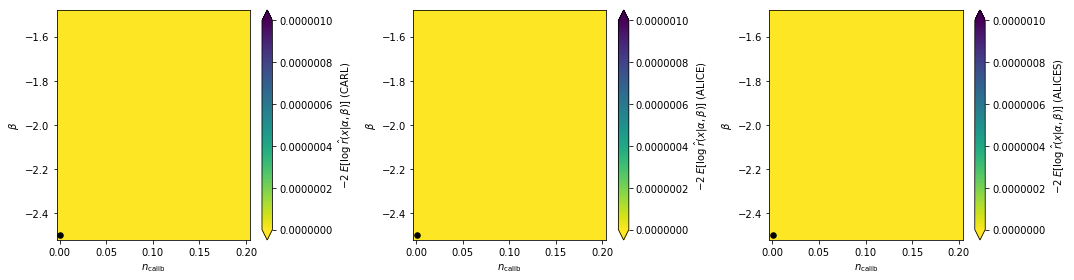

In [79]:
fig = plt.figure(figsize=(5. * nmethods, 4.))
ax_xs = []
ax_rs = []

for k in range(nmethods):
    ax = plt.subplot(1, nmethods, k + 1)

    i_mle = np.argmax(expected_llr[k])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * n * (expected_llr[k] - expected_llr[k][i_mle]), llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(150., -1.9, s=60., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$ ' + '({})'.format(labels[k]))
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])          
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_{}.pdf".format(setting))

## Example measurement of 100 images

In [32]:
llrmin, llrmax = 0., 10000.
llr_cmap = "viridis_r"


In [33]:
from scipy.stats import chi2, norm

p5sigma = 2. * norm.sf(5.)
threshold = chi2.isf(p5sigma, df=2)
print(threshold)

28.743702426857567


/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'c'
  s)


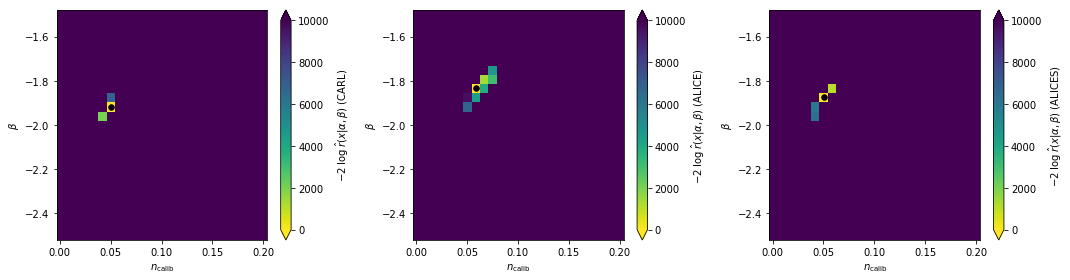

In [34]:
fig = plt.figure(figsize=(5.*nmethods, 4.))
ax_xs = []
ax_rs = []

for k in range(nmethods):
    ax = plt.subplot(1, nmethods, k + 1)

    i_mle = np.argmax(sum_llr_100[k])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (sum_llr_100[k] - sum_llr_100[k][i_mle]) , llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    
    plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        [threshold],
        c="black"
    )
    plt.scatter(150., -1.9, s=60., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])          
    
plt.tight_layout()
plt.savefig("../figures/llr100_{}.pdf".format(setting))